In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

/Users/janitabrock/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


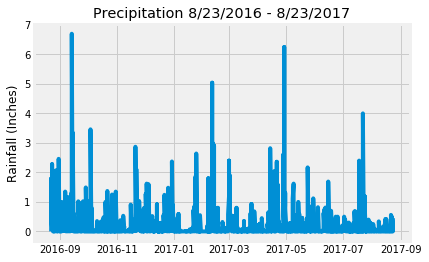

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
end_data_point = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())
    #print(end_data_point) allowed me to see the last date in the database

# Perform a query to retrieve the data and precipitation scores
climate_query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
order_by(Measurement.date).statement
    #print(climate_query)

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
climate_query_df=pd.read_sql(climate_query, engine).dropna()
#climate_query_df = climate_query_df.set_index('date')
climate_query_df = climate_query_df.sort_index(ascending=True)
climate_query_df.head(10)

# Use Pandas Plotting with Matplotlib to plot the data
climate_query_df['date']=pd.to_datetime(climate_query_df['date'])
plt.plot(climate_query_df['date'], climate_query_df['prcp'])
plt.title("Precipitation 8/23/2016 - 8/23/2017")
plt.xlabel('')
plt.ylabel('Rainfall (Inches)')
plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_query_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
total_stations=session.query(Station).count()
print(total_stations)

9


In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = (session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc()).all())
print(most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [48]:
# Using the station id from the previous query, calculate:

station_name = most_active_stations[0][0]

station_name_definer = (session.query(Station.name).filter_by(station = station_name))
station_name_definer = station_name_definer[0][0]

lowest_temp = (session.query(Measurement.tobs).filter(Measurement.station == station_name)
               .order_by(Measurement.tobs.asc()).first())
lowest_temp = lowest_temp[0]

highest_temp = (session.query(Measurement.tobs).filter(Measurement.station == station_name)
               .order_by(Measurement.tobs.desc()).first())
highest_temp= highest_temp[0]

average_temp = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_name))
average_temp = average_temp[0][0]


# highest temperature recorded, and average temperature most active station?

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {average_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


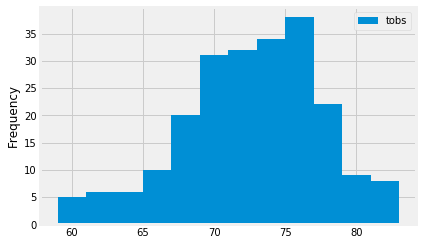

In [52]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > '2016-8-23')
            .filter(Measurement.station == station_name).order_by(Measurement.date).all())

temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df = temp_obs_df.set_index('date')
temp_obs_df = temp_obs_df.sort_index(ascending = True)

temp_obs_df.plot(kind='hist', bins = 12)

In [53]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [55]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_dates = '2012-02-28 to \n 2012-03-05'
trip_start = '2012-02-28'
trip_end = '2012-03-05'

trip_calc_temps = calc_temps(trip_start, trip_end)
trip_calc_temps

[(62.0, 69.57142857142857, 74.0)]

Text(0, 0.5, 'Temp (Fahrenheit)')

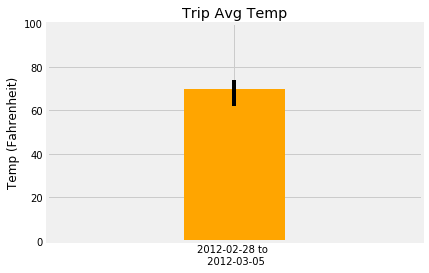

In [56]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_min = trip_calc_temps[0][0]
trip_max = trip_calc_temps[0][2]
trip_avg = trip_calc_temps[0][1]

error_min = trip_avg - trip_min
error_max = trip_max - trip_avg

errorbar = np.array([[error_min], [error_max]])

plt.bar(trip_dates, trip_avg, yerr=errorbar, color = 'orange')
plt.ylim(0,100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (Fahrenheit)')

In [59]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain = ([Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation])

rain_per_station = (session.query(*rain).filter(Station.station == Measurement.station).filter(Measurement.date >= trip_start)
                    .filter(Measurement.date <= trip_end).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc())
                    .all())
rain_per_station


[('USC00519281',
  'WAIHEE 837.5, HI US',
  11.08,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  10.32,
  21.3331,
  -157.8025,
  152.4),
 ('USC00513117', 'KANEOHE 838.1, HI US', 5.79, 21.4234, -157.8015, 14.6),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  3.8400000000000003,
  21.4992,
  -158.0111,
  306.6),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  2.92,
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  1.1800000000000002,
  21.2716,
  -157.8168,
  3.0),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  0.76,
  21.3152,
  -157.9992,
  0.9),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.03,
  21.5213,
  -157.8374,
  7.0),
 ('USC00517948', 'PEARL CITY, HI US', 0.0, 21.3934, -157.9751, 11.9)]